In [1]:
%matplotlib inline

import sys
sys.path.append("../")
from utils import DetectionDataset, draw_rectangle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# \[ SSD Network Model 구성하기 \]
---
---

[SSD Network](https://arxiv.org/abs/1512.02325)은 한번의 FeedForward로 사물을 포착하면서 사물을 분류할 수 있는 모델입니다. <br>

In [2]:
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Add, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

## 1. Base Network 구성하기
---

SSD Network는 기본적으로 `VGG-Network` Style을 따릅니다. 여기에서는 좀 더 빠른 수렴을 위해, Batch Normalization을 추가하고, MaxPooling을 제거하도록 하겠습니다. Max Pooling은 사물의 위치에 무관하게 특징을 잘 잡을 수 있도록 도와주지만, 역으로 사물의 위치 정보를 훼손시키기 때문에 Detection과 같은 Task를 수행할 때에는 제거해주는 것이 좋습니다.

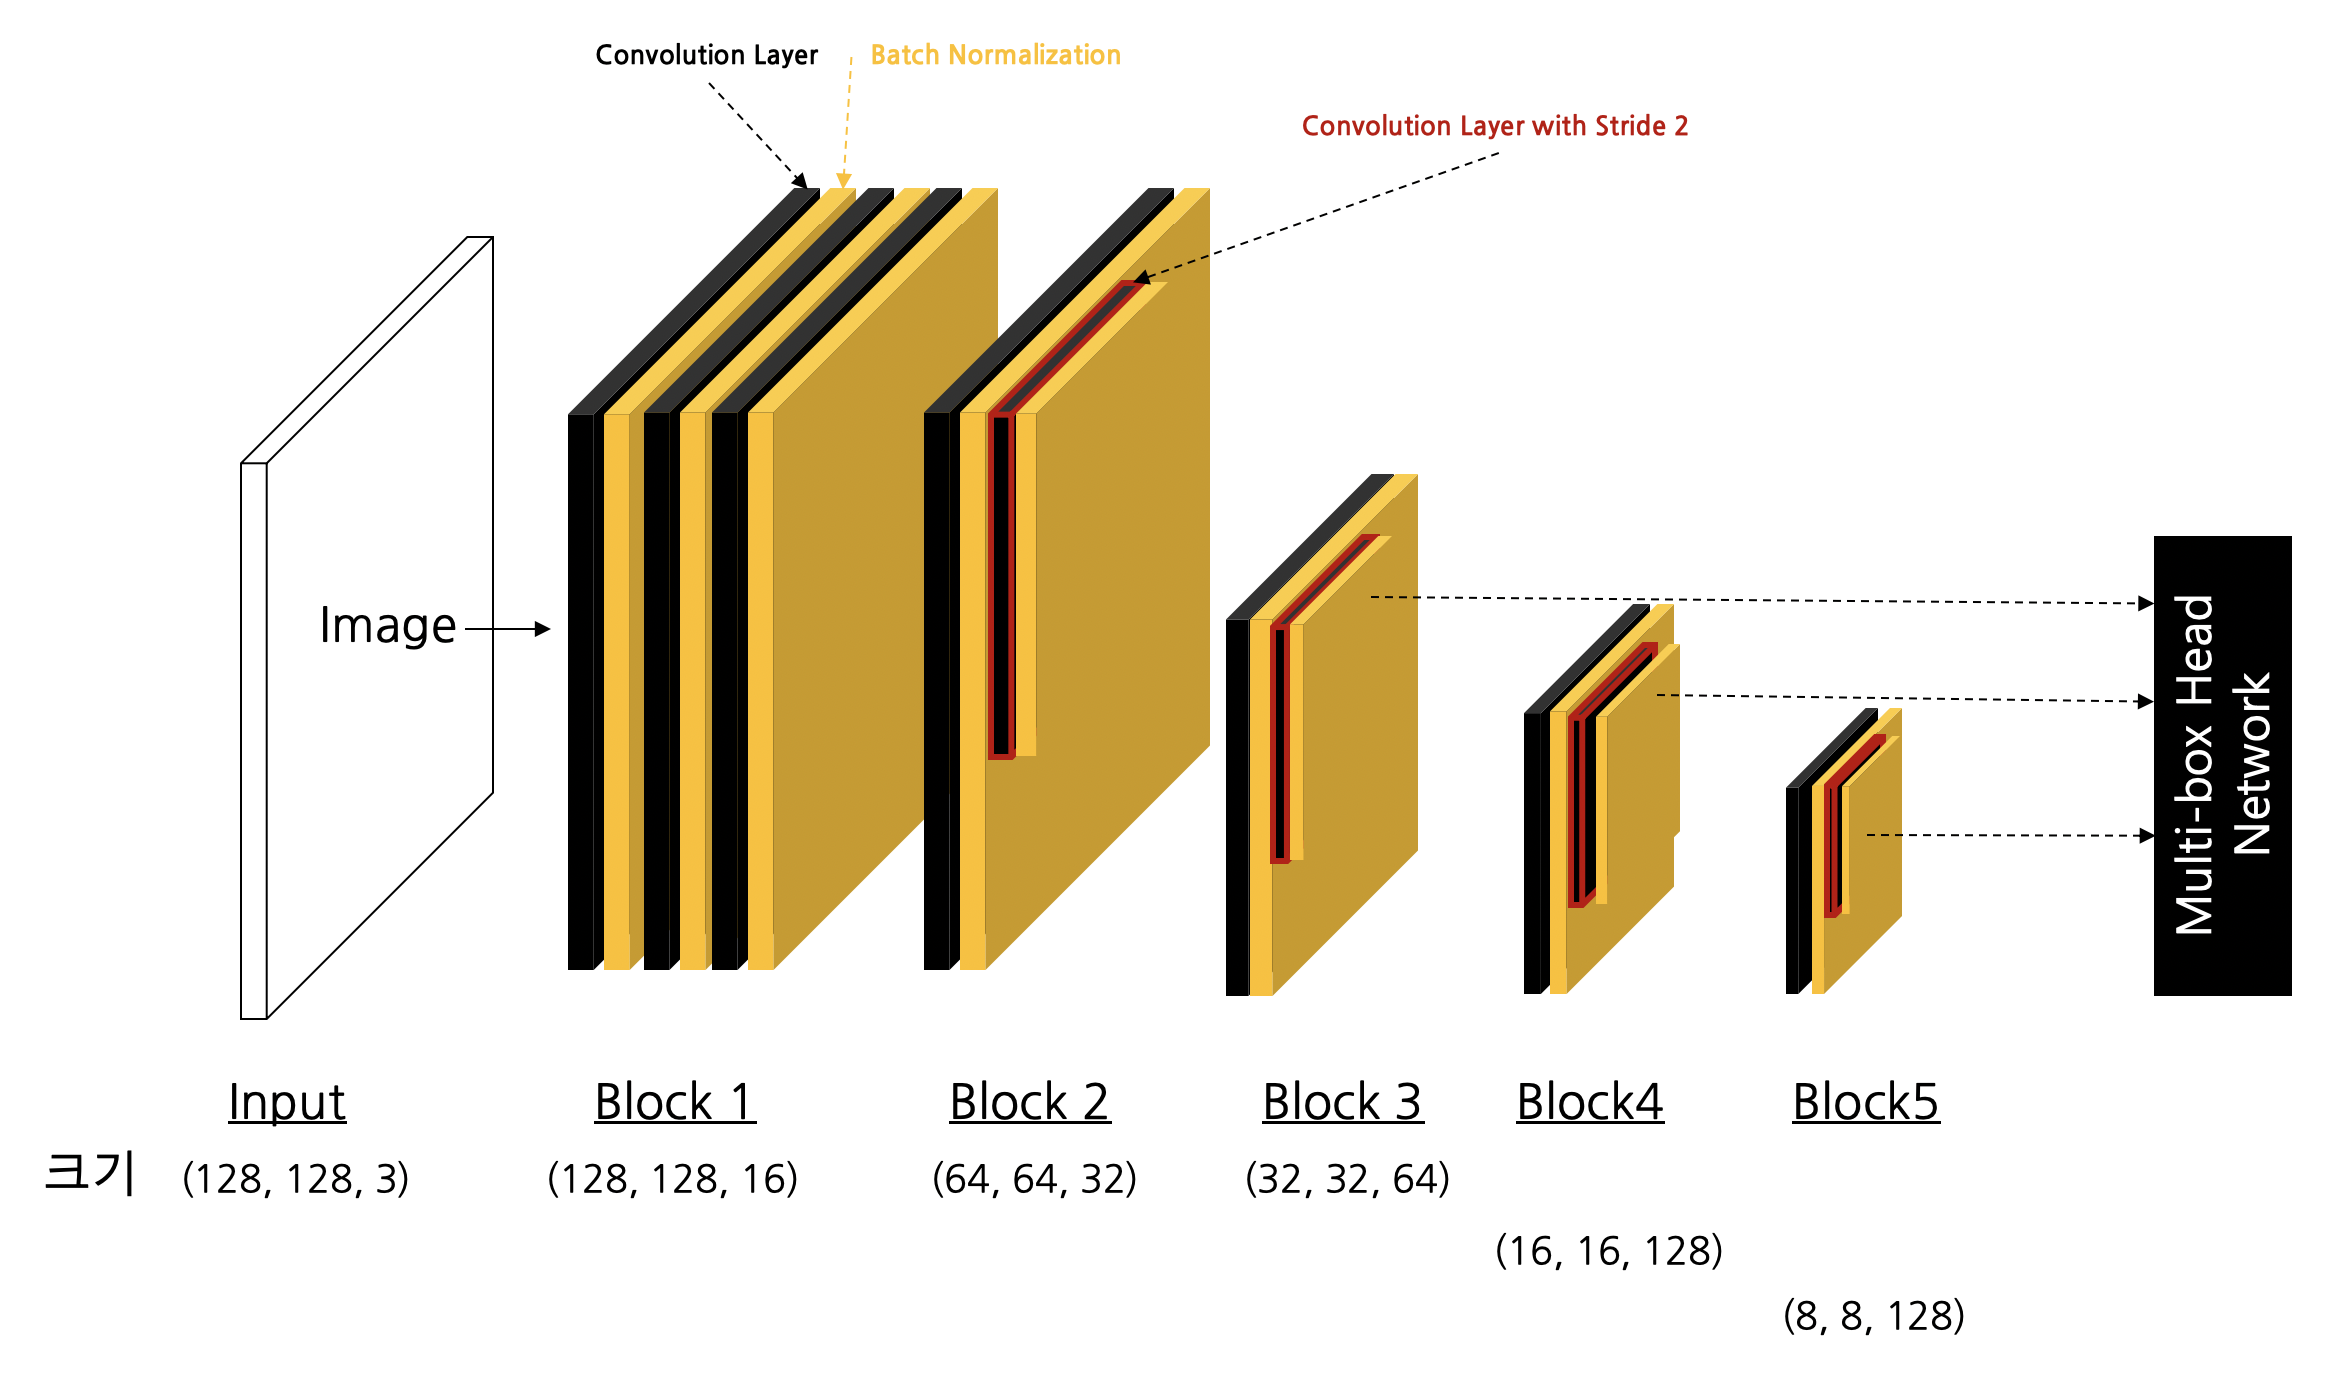

| layer name | num unit | filter size | stride | padding |
|---|---|---|---|---|
| `conv1_1` | 16 | (3,3) | (1,1) | same |
| `norm1_1` | - | - | - | - |
| `conv1_2` | 16 | (3,3) | (1,1) | same |
| `norm1_2` | - | - | - | - |
| `conv1_3` | 16 | (3,3) | (1,1) | same |
| `norm1_3` | - | - | - | - |
| `conv2_1` | 32 | (3,3) | (1,1) | same |
| `norm2_1` | - | - | - | - |
| `conv2_2` | 32 | (3,3) | (2,2) | same |
| `norm2_2` | - | - | - | - |
| `conv3_1` | 64 | (3,3) | (1,1) | same |
| `norm3_1` | - | - | - | - |
| `conv3_2` | 64 | (3,3) | (2,2) | same |
| `norm3_2` | - | - | - | - |
| `conv4_1` | 128 | (3,3) | (1,1) | same |
| `norm4_1` | - | - | - | - |
| `conv4_2` | 128 | (3,3) | (2,2) | same |
| `norm4_2` | - | - | - | - |
| `conv5_1` | 128 | (3,3) | (1,1) | same |
| `norm5_1` | - | - | - | - |
| `conv5_2` | 128 | (3,3) | (2,2) | same |
| `norm5_2` | - | - | - | - |

In [3]:
num_units = 16

K.clear_session()

inputs = Input(shape=(128,128,3)) 
# (None,None,3)으로 해야 이미지 크기에 무관하게 동작하지만, 
# 모델의 크기 변화를 확인하기 위해 (128,128,3)으로 고정시켰습니다.

# BLOCK 1
conv1_1 = Conv2D(num_units, (3, 3), strides=(1, 1), activation='relu',
                 padding='same', name='conv1_1')(inputs)
norm1_1 = BatchNormalization(name='norm1_1')(conv1_1)
conv1_2 = Conv2D(num_units, (3, 3), strides=(1, 1), activation='relu',
                 padding='same', name='conv1_2')(norm1_1)
norm1_2 = BatchNormalization(name='norm1_2')(conv1_2)
conv1_3 = Conv2D(num_units, (3, 3), strides=(1, 1), activation='relu',
                 padding='same', name='conv1_3')(norm1_2)
norm1_3 = BatchNormalization(name='norm1_3')(conv1_3)

# BLOCK 2
conv2_1 = Conv2D(num_units * 2, (3, 3), activation='relu',
                 padding='same', name='conv2_1')(norm1_3)
norm2_1 = BatchNormalization(name='norm2_1')(conv2_1)
conv2_2 = Conv2D(num_units * 2, (3, 3), strides=(2, 2), activation='relu',
                 padding='same', name='conv2_2')(norm2_1)
norm2_2 = BatchNormalization(name='norm2_2')(conv2_2)

# BLOCK 3
conv3_1 = Conv2D(num_units * 4, (3, 3), activation='relu',
                 padding='same', name='conv3_1')(norm2_2)
norm3_1 = BatchNormalization(name='norm3_1')(conv3_1)
conv3_2 = Conv2D(num_units * 4, (3, 3), strides=(2, 2), activation='relu',
                 padding='same', name='conv3_2')(norm3_1)
norm3_2 = BatchNormalization(name='norm3_2')(conv3_2)

# BLOCK 4
conv4_1 = Conv2D(num_units * 8, (3, 3), activation='relu',
                 padding='same', name='conv4_skip')(norm3_2)
norm4_1 = BatchNormalization(name='norm4_1')(conv4_1)
conv4_2 = Conv2D(num_units * 8, (3, 3), strides=(2, 2), activation='relu',
                 padding='same', name='conv4_2')(norm4_1)
norm4_2 = BatchNormalization(name='norm4_2')(conv4_2)

# Block 5
conv5_1 = Conv2D(num_units * 8, (3, 3), activation='relu',
                 padding='same', name='conv5_skip')(norm4_2)
norm5_1 = BatchNormalization(name='norm5_1')(conv5_1)
conv5_2 = Conv2D(num_units * 8, (3, 3), strides=(2, 2), activation='relu',
                 padding='same', name='conv5_2')(norm5_1)
norm5_2 = BatchNormalization(name='norm5_2')(conv5_2)

outputs = norm5_2

W0723 10:07:45.155193 4497569216 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
# BASE NETWORK 구성하기
base_network = Model(inputs, outputs,
                     name='base_network')

위 과정을 메소드로 구성하면 아래와 같습니다.

In [10]:
def build_base_network(input_shape=(None,None,3), num_units=16):
    K.clear_session()

    inputs = Input(shape=input_shape)

    # BLOCK 1
    conv1_1 = Conv2D(num_units, (3, 3), strides=(1, 1), activation='relu',
                     padding='same', name='conv1_1')(inputs)
    norm1_1 = BatchNormalization(name='norm1_1')(conv1_1)
    conv1_2 = Conv2D(num_units, (3, 3), strides=(1, 1), activation='relu',
                     padding='same', name='conv1_2')(norm1_1)
    norm1_2 = BatchNormalization(name='norm1_2')(conv1_2)
    conv1_3 = Conv2D(num_units, (3, 3), strides=(1, 1), activation='relu',
                     padding='same', name='conv1_3')(norm1_2)
    norm1_3 = BatchNormalization(name='norm1_3')(conv1_3)

    # BLOCK 2
    conv2_1 = Conv2D(num_units * 2, (3, 3), activation='relu',
                     padding='same', name='conv2_1')(norm1_3)
    norm2_1 = BatchNormalization(name='norm2_1')(conv2_1)
    conv2_2 = Conv2D(num_units * 2, (3, 3), strides=(2, 2), activation='relu',
                     padding='same', name='conv2_2')(norm2_1)
    norm2_2 = BatchNormalization(name='norm2_2')(conv2_2)

    # BLOCK 3
    conv3_1 = Conv2D(num_units * 4, (3, 3), activation='relu',
                     padding='same', name='conv3_1')(norm2_2)
    norm3_1 = BatchNormalization(name='norm3_1')(conv3_1)
    conv3_2 = Conv2D(num_units * 4, (3, 3), strides=(2, 2), activation='relu',
                     padding='same', name='conv3_2')(norm3_1)
    norm3_2 = BatchNormalization(name='norm3_2')(conv3_2)

    # BLOCK 4
    conv4_1 = Conv2D(num_units * 8, (3, 3), activation='relu',
                     padding='same', name='conv4_skip')(norm3_2)
    norm4_1 = BatchNormalization(name='norm4_1')(conv4_1)
    conv4_2 = Conv2D(num_units * 8, (3, 3), strides=(2, 2), activation='relu',
                     padding='same', name='conv4_2')(norm4_1)
    norm4_2 = BatchNormalization(name='norm4_2')(conv4_2)

    # Block 5
    conv5_1 = Conv2D(num_units * 8, (3, 3), activation='relu',
                     padding='same', name='conv5_skip')(norm4_2)
    norm5_1 = BatchNormalization(name='norm5_1')(conv5_1)
    conv5_2 = Conv2D(num_units * 8, (3, 3), strides=(2, 2), activation='relu',
                     padding='same', name='conv5_2')(norm5_1)
    norm5_2 = BatchNormalization(name='norm5_2')(conv5_2)

    outputs = norm5_2

    return Model(inputs, outputs, name='base_network')

In [11]:
base_network = build_base_network((128,128,3),16)

## 2. Multi-Box Head Network 구성하기
---

우리는 지정한 각 층에서 별도로 Classification과 Localization을 수행하는 Head network들을 둡니다. 하나의 Feature Map에서만 Head Network를 두는 것이 아니라, 여러 개의 Feature Map에 head Network를 둚으로써, 큰 이미지의 사물과 작은 이미지의 사물을 동시에 잘 잡아낼 수 있도록 설계하였습니다.

![Imgur](https://i.imgur.com/dvSx4JF.jpg)

Sub Network는 전혀 복잡한 것이 아닙니다. 3x3 Convolution Layer에 위치 정보 Regressor는 출력 갯수가 4개(cx,cy,w,h)가 되도록, 라벨 정보 Classifier는 출력 갯수가 클래스 숫자만큼 되도록 구성하기만 하면 됩니다.

In [18]:
from tensorflow.keras.layers import Flatten, Concatenate, Reshape

In [19]:
num_classes = 10 
num_priors = 3

source_layer_names = ['norm3_2','norm4_2','norm5_2']

clf_heads = []
loc_heads = []
for idx, layer_name in enumerate(source_layer_names):
    source_layer = base_network.get_layer(layer_name).output 
    
    # Classification
    clf = Conv2D(num_priors * (num_classes+1), (3,3),
                 activation='softmax', padding='same', 
                 name=f'clf_head_{idx}')(source_layer)
    clf = Reshape((-1, num_classes+1),
                  name=f'clf_head_{idx}_reshape')(clf)
    clf_heads.append(clf)
    
    # Localization
    loc = Conv2D(num_priors * 4, (3,3), padding='same', 
                 name=f'head{idx}_loc')(source_layer)
    loc = Reshape((-1,4),
                  name=f'head{idx}_loc_flatten')(loc)
    loc_heads.append(loc)

clf_concat = Concatenate(axis=1, name='clf_head_concat')(clf_heads)
loc_concat = Concatenate(axis=1, name='loc_head_concat')(loc_heads)
predictions = Concatenate(axis=-1, name='predictions')([clf_concat,
                                                        loc_concat])

위를 메소드로 구현하면 아래와 같습니다.

In [20]:
def attach_multibox_head(base_network, source_layer_names, 
                         num_priors=3, num_classes=10):
    clf_heads = []
    loc_heads = []
    for idx, layer_name in enumerate(source_layer_names):
        source_layer = base_network.get_layer(layer_name).output 

        # Classification
        clf = Conv2D(num_priors * (num_classes+1), (3,3),
                     activation='softmax', padding='same', 
                     name=f'clf_head{idx}')(source_layer)
        clf = Reshape((-1, num_classes+1),
                      name=f'clf_head{idx}_reshape')(clf)
        clf_heads.append(clf)

        # Localization
        loc = Conv2D(num_priors * 4, (3, 3), padding='same', 
                     name=f'loc_head{idx}')(source_layer)
        loc = Reshape((-1,4),
                      name=f'loc_head{idx}_reshape')(loc)
        loc_heads.append(loc)

    clf_concat = Concatenate(axis=1, name='clf_heads_concat')(clf_heads)
    loc_concat = Concatenate(axis=1, name='loc_heads_concat')(loc_heads)
    predictions = Concatenate(axis=-1, name='predictions')([clf_concat,
                                                            loc_concat])
    return predictions

### 구현된 모든 메소드를 통해 우리의 Tiny SSD를 구성해보도록 하겠습니다.

In [21]:
base_network = build_base_network((128,128,3), num_units=16)
predictions = attach_multibox_head(base_network,
                                   ['norm3_2','norm4_2','norm5_2'])
tiny_ssd = Model(base_network.input, predictions)

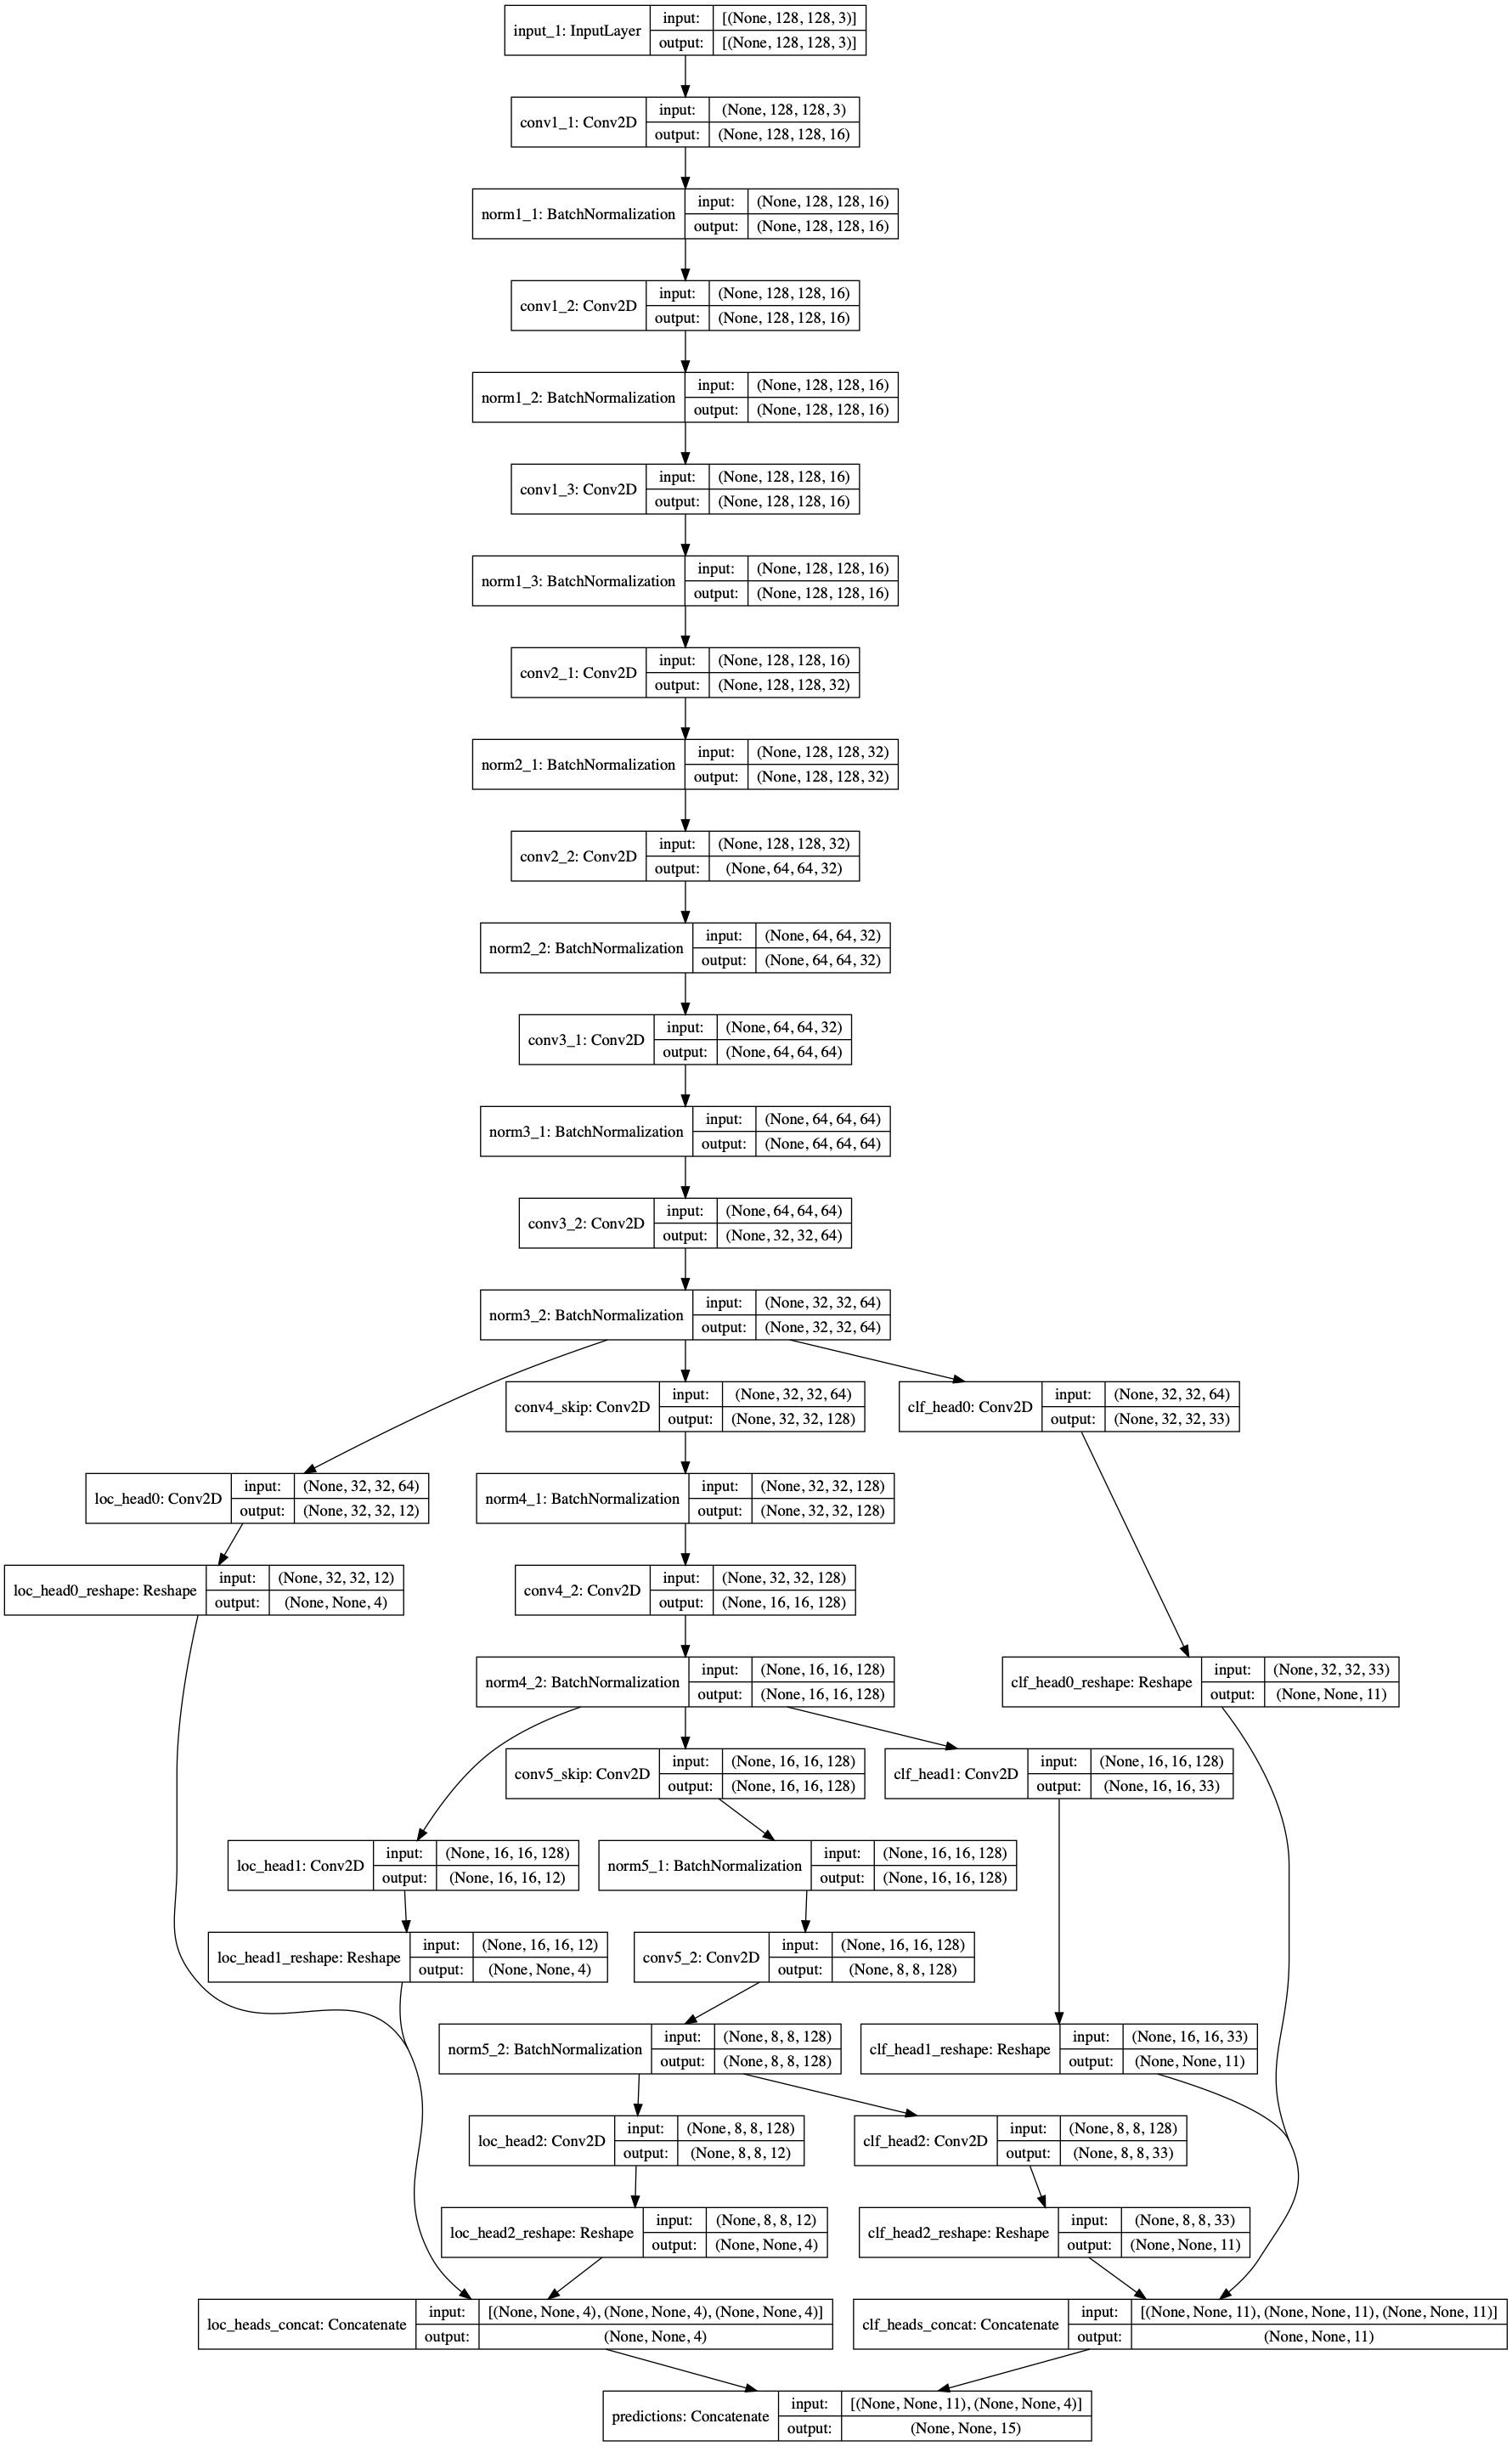

In [22]:
plot_model(tiny_ssd,show_shapes=True)

In [23]:
tiny_ssd.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
norm1_1 (BatchNormalization)    (None, 128, 128, 16) 64          conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 128, 128, 16) 2320        norm1_1[0][0]                    
______________________________________________________________________________________________